In [ ]:
import importlib
# based on 
# import sleep
import scipy
import anndata as ad
from scipy.optimize import linear_sum_assignment

# import mudata as md
from anndata import AnnData
# import muon
# ignore warnings
import warnings
import os
from scipy.sparse import issparse
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvi
import re
from scvi.model import SCVI
from scvi.train import TrainingPlan
import torch

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import bar_nick_utils

importlib.reload(bar_nick_utils)

from bar_nick_utils import preprocess_rna, preprocess_protein, plot_archetypes, \
    get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal, evaluate_distance_metrics, \
    plot_archetypes_matching, compare_matchings, find_best_pair_by_row_matching, verify_gradients, plot_latent, \
    compute_pairwise_kl

plot_flag = False                                        
device = "cuda:0" if torch.cuda.is_available() else "cpu"
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
np.set_printoptions(threshold=100) 
np.random.seed(0)
plot_flag = True
save_dir = 'data/totalVI'

In [ ]:
folder = 'data/'
file_prefixes = ['adata_rna_', 'adata_prot_', 'adata_archetype_rna_', 'adata_archetype_prot_']

# Function to get the latest file based on the timestamp
def get_latest_file(prefix):
    files = [f for f in os.listdir(folder) if f.startswith(prefix) and f.endswith('.h5ad')]
    if not files:
        return None
    files.sort(key=lambda x: re.search(r'\d{4}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}', x).group(), reverse=True)
    return os.path.join(folder, files[0])


# Load the latest files
latest_files = {prefix: get_latest_file(prefix) for prefix in file_prefixes}
adata_rna = sc.read(latest_files['adata_rna_'])
adata_prot = sc.read(latest_files['adata_prot_'])
adata_archetype_rna = sc.read(latest_files['adata_archetype_rna_'])
adata_archetype_prot = sc.read(latest_files['adata_archetype_prot_'])
# sc.pp.neighbors(adata_prot)
# sc.tl.umap(adata_prot)
# sc.pl.umap(adata_prot)

In [ ]:
adata_rna.obsm['archetype_vec'] = pd.DataFrame(adata_archetype_rna.X,index=adata_rna.obs.index)
adata_prot.obsm['archetype_vec'] = pd.DataFrame(adata_archetype_prot.X,index=adata_prot.obs.index)
# filter out the types that are not in the mapping form the mapping



In [ ]:
sample_size = min(len(adata_prot), len(adata_rna), 1000)
adata_prot_subset = sc.pp.subsample(adata_prot, n_obs=sample_size, copy=True)
adata_rna_subset = sc.pp.subsample(adata_rna, n_obs=sample_size, copy=True)
del adata_prot, adata_rna

In [ ]:
# generate major cell types
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
major_to_minor_dict ={}
# from major to minor dict
for k,v in cell_type_mapping.items():
    if v not in major_to_minor_dict:
        major_to_minor_dict[v] = [k]
    else:
        major_to_minor_dict[v].append(k)

In [ ]:
# Map the specific cell types to major cell types and add as a new column in obs
adata_rna_subset.obs['major_cell_types'] = pd.Categorical( adata_rna_subset.obs['cell_types'].map(cell_type_mapping))
adata_prot_subset.obs['major_cell_types'] =pd.Categorical(  adata_rna_subset.obs['cell_types'].map(cell_type_mapping))
# sort by major cell types for better visualization
# adata_rna_subset = adata_rna_subset[adata_rna_subset.obs['major_cell_types'].sort_values().index]
# adata_prot_subset = adata_prot_subset[adata_prot_subset.obs['major_cell_types'].sort_values().index]
# Sort adata_rna_subset by major and minor cell types
adata_rna_subset = adata_rna_subset[
    adata_rna_subset.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]

# Sort adata_prot_subset by major and minor cell types
adata_prot_subset = adata_prot_subset[
    adata_prot_subset.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]


In [ ]:

# protein_archetype_vecs = adata_prot_subset.obsm['archetype_vec']
# rna_archetype_vecs = (rna_archetype_vecs -    rna_archetype_vecs.mean()) / rna_archetype_vecs.std()
# protein_archetype_vecs = (protein_archetype_vecs - protein_archetype_vecs.mean()) / protein_archetype_vecs.std()
plt.figure(figsize=(10, 5))
plt.suptitle('Heatmap of archetype coor before matching (only good if useing CITE-seq data)')
plt.subplot(1,2,1)
sns.heatmap((adata_rna_subset.obsm['archetype_vec'].values))
plt.subplot(1,2,2)
sns.heatmap((adata_prot_subset.obsm['archetype_vec'].values))
plt.show()

In [ ]:
# archetype_distances = scipy.spatial.distance.cdist(adata_rna_subset.obsm['archetype_vec'].values,
#                                                adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
#                                                    # adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
# matching_distance_before = np.diag(archetype_distances).mean()
# matching_cells = np.argmin(archetype_distances,axis=1)
# adata_prot_subset_ = adata_prot_subset[matching_cells] # TODO this make sure that the cells are aligned! this is the problme deal with it


In [ ]:
# add archetype_distances to adata_rna_subset
# set the archtyeps distances from rna to protein
# set the archetype distances to the rna adata
# sc.pp.neighbors(adata_prot_subset)
# sc.tl.umap(adata_prot_subset)
# sc.pl.umap(adata_prot_subset)
# TODO I do RNA to RNA DISTANCES!!! should repalce this with RNA to protein distances!!!!
# if adata_prot_subset.uns.get('ordered_matching_cells') is None: # to avoid multiple matchinging
archetype_distances = scipy.spatial.distance.cdist(adata_rna_subset.obsm['archetype_vec'].values,
                                               adata_rna_subset.obsm['archetype_vec'].values,metric='cosine')
                                                   # adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
matching_distance_before = np.diag(archetype_distances).mean()
# matching_cells = np.argmin(archetype_distances,axis=1)
row_ind, col_ind = linear_sum_assignment(archetype_distances)
matching_cells = col_ind

# change X to avoid changes obs order . is that correct?
adata_prot_subset.X = adata_prot_subset.X[matching_cells] # TODO this make sure that the cells are aligned! this is the problme deal with it
adata_prot_subset.uns['ordered_matching_cells'] = True

archetype_distances = scipy.spatial.distance.cdist(adata_rna_subset.obsm['archetype_vec'].values,
                                                   adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
                                                   # adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
random_order_archetype_distances = scipy.spatial.distance.cdist(adata_rna_subset.obsm['archetype_vec'].values,
                                                                np.random.permutation(adata_prot_subset.obsm['archetype_vec'].values),metric='cosine')
matching_distance_after = np.diag(archetype_distances).mean()
print(f'Matching distance before {matching_distance_before} and after {matching_distance_after}\n diff is {matching_distance_before-matching_distance_after}\n random order distance is {np.diag(random_order_archetype_distances).mean()}')
adata_rna_subset.obsm['archetype_distances'] = archetype_distances


In [ ]:
# adata_rna_subset.obs['matching_protein_cells'] = matching_cells
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

sns.heatmap(np.log1p(archetype_distances[:1000,:1000].T))
plt.gca().invert_yaxis()
# plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.scatter(np.arange(len(archetype_distances.argmin(axis=1))),archetype_distances.argmin(axis=1),s=1)
plt.title('If this looks like a line, then the matching ARE THE SAME AND NOT ACROSS MODALITIES')

plt.show()
adata_rna_subset.obs['index_col'] = np.arange(adata_rna_subset.shape[0])
adata_prot_subset.obs['index_col'] = np.arange(adata_prot_subset.shape[0])


In [ ]:
plt.figure(figsize=(10, 5))
plt.suptitle('Archetype coor between RNA and protein after matching')
plt.subplot(1,2,1)
sns.heatmap((adata_rna_subset.obsm['archetype_vec'].values))
plt.subplot(1,2,2)
sns.heatmap((adata_prot_subset.obsm['archetype_vec'].values))
plt.show()

In [ ]:
sc.pp.pca(adata_rna_subset, n_comps=50)
sc.pp.pca(adata_prot_subset, n_comps=50)
sc.pp.neighbors(adata_rna_subset,key_added='original_neighbors')
sc.tl.umap(adata_rna_subset,neighbors_key='original_neighbors')
adata_rna_subset.obsm['X_original_umap'] = adata_rna_subset.obsm["X_umap"]
sc.pp.neighbors(adata_prot_subset,key_added='original_neighbors')
sc.tl.umap(adata_prot_subset,neighbors_key='original_neighbors')
adata_prot_subset.obsm['X_original_umap'] = adata_prot_subset.obsm["X_umap"]

if plot_flag:
    sc.pl.pca(adata_rna_subset,color=['cell_types','major_cell_types'])
    sc.pl.pca(adata_prot_subset,color=['cell_types','major_cell_types'])
    sc.pl.embedding(adata_rna_subset,basis='X_umap',color=['cell_types','major_cell_types'])
    sc.pl.embedding(adata_prot_subset,basis='X_original_umap',color=['cell_types','major_cell_types'])


In [ ]:
if plot_flag:
    adata_B_cells = adata_rna_subset[adata_rna_subset.obs['major_cell_types']=='B cells']
    sc.pp.pca(adata_B_cells)
    sc.pp.neighbors(adata_B_cells, use_rep='X_pca')
    sc.tl.umap(adata_B_cells)
    sc.pl.umap(adata_B_cells, color=['tissue'], title='verifying tissue does not give a major effect')


In [ ]:
# and placing the cells in the regions
adata_prot_subset,horizontal_splits,vertical_splits = add_spatial_data_to_prot(adata_prot_subset, major_to_minor_dict)
if plot_flag:
    sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')
    sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='CD4 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')
    sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='CD8 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')


In [ ]:
sc.pp.neighbors(adata_prot_subset)
connectivities = adata_prot_subset.obsp['connectivities']
connectivities[connectivities>0]=1
assert np.array_equal(np.array([0., 1.], dtype=np.float32), np.unique(np.array(connectivities.todense())))
if plot_flag:
    # sns.heatmap(connectivities.todense()[:1000,:1000])
    sns.heatmap(connectivities.todense()[:1000,:1000])

In [ ]:
neighbor_sums = connectivities.dot(adata_prot_subset.X) # get the sum of all neighbors
neighbor_means = neighbor_sums/(0.00001+neighbor_sums.sum(1))[:,np.newaxis] # normalize
if plot_flag:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.scatterplot(neighbor_means[:50,:3])
    plt.subplot(1,2,2)
    plt.scatter(neighbor_means[:50,0],neighbor_means[:50,1])

In [ ]:
# Standardize the data
normalized_data = zscore(neighbor_means, axis=0)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(normalized_data)

final_labels = np.array(kmeans.labels_)
if 'CN' in adata_prot_subset.obs:
    adata_prot_subset.obs.drop(columns=['CN'], inplace=True, errors='ignore')
    adata_rna_subset.obs.drop(columns=['CN'], inplace=True, errors='ignore')
adata_prot_subset.obs['CN'] = pd.Categorical(final_labels)
adata_rna_subset.obs['CN'] = pd.Categorical(final_labels)
num_clusters = len(adata_prot_subset.obs['CN'].unique())

palette = sns.color_palette("tab10", num_clusters)  # "tab10" is a good color map, you can choose others too
adata_prot_subset.uns['spatial_clusters_colors'] = palette.as_hex()  # Save as hex color codes
fig, ax = plt.subplots()
sc.pl.scatter(
    adata_prot_subset,
    x='X', y='Y',
    color='CN',
    title='Cluster cells by their CN, can see the different CN in different regions, \nthanks to the different B cell types in each region',
    ax=ax,  # Use the ax created above
    show=False  # Prevent scanpy from showing the plot immediately
)
for x in horizontal_splits[1:-1]:  # Exclude the edges to avoid border doubling
    ax.axvline(x=x, color='black', linestyle='--')
for y in vertical_splits[1:-1]:  # Exclude the edges to avoid border doubling
    ax.axhline(y=y, color='black', linestyle='--')

In [ ]:
# sc.pp.neighbors(adata_prot_subset, use_rep='X_neighborhood', key_added='X_neighborhood')
# sc.tl.umap(adata_prot_subset, neighbors_key='X_neighborhood')
# sc.pl.umap(adata_prot_subset, color='CN', title='UMAP of CN vectors colored by CN label')
# sc.pl.umap(adata_prot_subset, color='CN', title='UMAP of CN vectors colored by CN label',neighbors_key='original_neighbors',)
# sc.pl.umap(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'], color='cell_types', title='UMAP of CN vectors colored by minor cell type label')
adata_prot_subset

In [ ]:
if plot_flag:
    sns.histplot(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'].obs, x='cell_types',hue='CN', multiple='fill', stat='proportion')
    # sns.histplot(adata_prot_subset.obs, x='cell_types',hue='CN', multiple='fill', stat='proportion')
    plt.title('Showcasing the signature CN progile of each minor B cell type')

In [ ]:
if plot_flag:
    # sc.pl.embedding(adata_rna_subset, color=["major_cell_types","cell_types"], basis='X_original_umap',title='Original data major minor cell types')
    # sc.pl.embedding(adata_prot_subset, color=["major_cell_types","cell_types"], basis='X_original_umap',title='Original data major and minor cell types')
    
    # sc.pl.umap(adata_rna_subset, color="CN",neighbors_key='original_neighbors',title='Original RNA data CN')
    sc.pl.embedding(adata_rna_subset, color=["CN","cell_types"],basis='X_original_umap',title='Original rna data CN')
    sc.pl.embedding(adata_rna_subset, color=["CN","cell_types"],basis='X_original_umap',title='Original rna data CN')
    # sc.pl.umap(adata_prot_subset, color="CN",neighbors_key='original_neighbors',title='Original protein data CN')
    sc.pl.embedding(adata_prot_subset, color=["CN","cell_types"],basis='X_original_umap',title='Original protein data CN')
    sc.pl.umap(adata_prot_subset[adata_prot_subset.obs['major_cell_types'] =='B cells'], color="cell_types",neighbors_key='original_neighbors',title='Latent space MINOR cell types, B cells only')



In [ ]:
# # Define your custom data splitter
# class CustomDataSplitter(scvi.dataloaders.DataSplitter):
#     def __init__(self, adata_manager, *args, **kwargs):
#         super().__init__(adata_manager, *args, **kwargs)
#         self.adata_manager = adata_manager
#         # Calculate sample weights based on label distribution
#         cn_labels = adata_manager.adata.obs["CN"].values  # Replace "CN" with your label column
#         unique_labels, counts = np.unique(cn_labels, return_counts=True)
#         class_weights = {label: 1.0 / count for label, count in zip(unique_labels, counts)}
#         self.sample_weights = torch.tensor([class_weights[cn] for cn in cn_labels], dtype=torch.float)
# 
#     def train_dataloader(self):
#         """Create the train data loader with weighted sampling."""
#         sampler = WeightedRandomSampler(
#             weights=self.sample_weights[self.train_idx],  # Only weights for training samples
#             num_samples=len(self.train_idx),
#             replacement=True
#         )
#         return AnnDataLoader(
#             self.adata_manager,
#             indices=self.train_idx,
#             sampler=sampler,
#             drop_last=False,
#             **self.data_loader_kwargs
#         )


In [ ]:
# import numpy as np
# import pandas as pd
# from anndata import AnnData
# 
# def balance_adata_by_duplication(adata, class_key):
#     """
#     Balance the AnnData object by duplicating samples from smaller classes to match the largest class size.
# 
#     Parameters:
#     - adata: AnnData object
#     - class_key: the key in adata.obs that contains the class labels
# 
#     Returns:
#     - new_adata: balanced AnnData object
#     """
#     # Get counts per class
#     class_counts = adata.obs[class_key].value_counts()
#     max_count = class_counts.max()
# 
#     balanced_indices = []
#     for cell_type in class_counts.index:
#         indices = np.where(adata.obs[class_key] == cell_type)[0]
#         n_samples = indices.shape[0]
#         n_to_sample = max_count - n_samples
#         # Sample with replacement to match the max_count
#         if n_to_sample > 0:
#             # Duplicate indices as needed
#             duplicated_indices = np.random.choice(indices, size=n_to_sample, replace=True)
#             all_indices = np.concatenate([indices, duplicated_indices])
#         else:
#             # If already at max count, use the indices as is
#             all_indices = indices
#         balanced_indices.extend(all_indices)
#     # Now create new adata with balanced indices
#     balanced_indices = np.array(balanced_indices)
#     # Shuffle the indices to mix the duplicated samples
#     np.random.shuffle(balanced_indices)
#     new_adata = adata[balanced_indices].copy()
#     # Optionally, add a column indicating whether a sample is original or duplicated
#     new_adata.obs['is_duplicate'] = ['Original' if idx in indices else 'Duplicate' for idx in balanced_indices]
#     return new_adata
# 
# # Usage example:
# # Suppose adata_rna_subset is your AnnData object, and 'CN' is the key in adata.obs that contains the class labels
# 
# balanced_adata = balance_adata_by_duplication(adata_rna_subset, class_key='CN')
# balanced_adata

In [ ]:
# # save the adata of extrnal processing
# # adata_rna_subset = sc.read('adata_rna_subset.hd5ad')
# # adata_prot_subset = sc.read('adata_prot_subset.hd5ad')
# # must do it for it to be able to load the adata
# # Convert obsm archetype_vec to numpy array for adata_rna_subset
# if 'archetype_vec' in adata_rna_subset.obsm:
#     adata_rna_subset.obsm['archetype_vec'] = np.array(adata_rna_subset.obsm['archetype_vec'])
# if 'archetype_vec' in adata_prot_subset.obsm:
#     adata_prot_subset.obsm['archetype_vec'] = np.array(adata_prot_subset.obsm['archetype_vec'])
# if 'spatial_clusters_colors' in adata_rna_subset.uns:
#     adata_rna_subset.uns['spatial_clusters_colors'] = list(adata_rna_subset.uns['spatial_clusters_colors'])
# if 'spatial_clusters_colors' in adata_prot_subset.uns:
#     adata_prot_subset.uns['spatial_clusters_colors'] = list(adata_prot_subset.uns['spatial_clusters_colors'])
# 
# 
# sc.write('/home/barroz/projects/Mapping-scRNA-seq-Variability-Using-Co-Embedding-to-Understand-Cell-Neighborhood-Effects/CITE-seq_RNA_seq/adata_rna_subset',adata_rna_subset)
# sc.write('/home/barroz/projects/Mapping-scRNA-seq-Variability-Using-Co-Embedding-to-Understand-Cell-Neighborhood-Effects/CITE-seq_RNA_seq/adata_prot_subset',adata_prot_subset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/2:   0%|          | 0/2 [00:00<?, ?it/s]

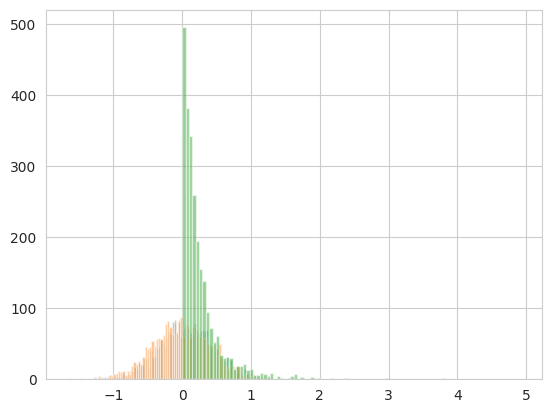

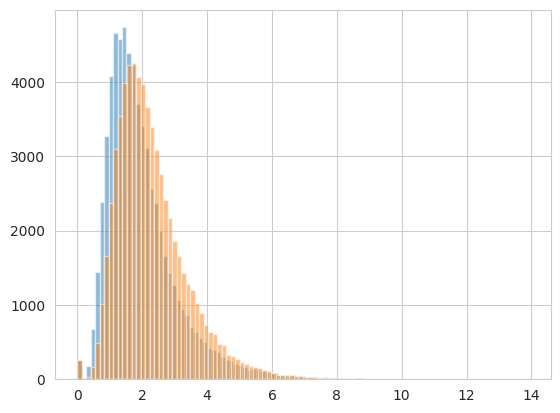

Epoch 2/2: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 2/2: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s, v_num=1]


In [109]:
class DualVAETrainingPlan(TrainingPlan):
    def __init__(self, rna_module, **kwargs):
        protein_vae = kwargs.pop('protein_vae')
        rna_vae = kwargs.pop('rna_vae')
        contrastive_weight = kwargs.pop('contrastive_weight', 1.0)
        super().__init__(protein_vae.module, **kwargs)
        super().__init__(rna_vae.module, **kwargs)
        # protein_vae.is_trained = True
        # rna_vae.is_trained = True

        self.rna_vae = rna_vae
        self.protein_vae = protein_vae
        self.prev = None
        self.contrastive_weight = contrastive_weight
        self.protein_vae.module.to(device)
        self.rna_vae.module = self.rna_vae.module.to(device)
        self.first_step = True

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            list(self.rna_vae.module.parameters()) + list(self.protein_vae.module.parameters()),
            lr=0.001,
            weight_decay=1e-5,
        )
        return optimizer

    def validation_step(self, batch, batch_idx):
        pass

    #     """Validation step for the model."""
    #     # RNA VAE forward pass
    #     _, _, rna_loss_output = self.forward(batch)
    #
    #     # Protein VAE forward pass
    #     protein_batch = self._get_protein_batch(batch)
    #     _, _, protein_loss_output = self.protein_vae.module.forward(protein_batch)
    #
    #     # Inference outputs
    #     rna_inference_outputs = self.rna_vae.module.inference(
    #         batch["X"], batch_index=batch["batch"], n_samples=1
    #     )
    #     protein_inference_outputs = self.protein_vae.module.inference(
    #         protein_batch["X"], batch_index=protein_batch["batch"], n_samples=1
    #     )
    #
    #     # Compute latent distances
    #     matching_rna_protein_latent_distances = torch.distributions.kl_divergence(
    #         rna_inference_outputs["qz"], protein_inference_outputs["qz"]
    #     )
    #
    #     # Compute pairwise distances for RNA and protein
    #     rna_distances = compute_pairwise_kl(
    #         rna_inference_outputs["qz"].mean, rna_inference_outputs["qz"].scale
    #     )
    #     prot_distances = compute_pairwise_kl(
    #         protein_inference_outputs["qz"].mean, protein_inference_outputs["qz"].scale
    #     )
    #
    #     # Compute contrastive loss
    #     cell_neighborhood_info = torch.tensor(
    #         self.rna_vae.adata[batch["labels"].cpu().numpy().squeeze()].obs["CN"].values).to(device)
    #     # index = batch["labels"].detach().cpu().numpy().squeeze()
    #     #
    #     # cell_neighborhood_info = torch.tensor(self.rna_vae.adata[index].obs["CN"].values).to(device)
    #
    #     major_cell_type = torch.tensor(
    #         self.rna_vae.adata[batch["labels"].cpu().numpy().squeeze()].obs["major_cell_types"].values.codes).to(
    #         device).squeeze()
    #
    #     num_cells = cell_neighborhood_info.shape[0]
    #     diagonal_mask = torch.eye(num_cells, dtype=torch.bool, device=cell_neighborhood_info.device)
    #
    #     same_cn_mask = cell_neighborhood_info.unsqueeze(0) == cell_neighborhood_info.unsqueeze(1)
    #     same_major_cell_type = major_cell_type.unsqueeze(0) == major_cell_type.unsqueeze(1)
    #
    #     distances = prot_distances  # or combine with RNA distances if necessary
    #     distances = distances.masked_fill(diagonal_mask, 0)
    #
    #     same_major_type_same_cn_loss = (distances ** 2) * (same_major_cell_type * same_cn_mask).type(torch.bool)
    #     same_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * (
    #                 same_major_cell_type * ~same_cn_mask).type(torch.bool)
    #     different_major_type_same_cn_loss = ((10 - distances).clamp(min=0) ** 2) * (
    #                 ~same_major_cell_type * same_cn_mask).type(torch.bool)
    #     different_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * (
    #                 ~same_major_cell_type * ~same_cn_mask).type(torch.bool)
    #
    #     cn_loss = (
    #                       same_major_type_same_cn_loss.sum() +
    #                       same_major_type_different_cn_loss.sum() +
    #                       different_major_type_same_cn_loss.sum() +
    #                       different_major_type_different_cn_loss.sum()
    #               ) / (num_cells * (num_cells - 1))
    #
    #     # Total loss
    #     total_loss = (
    #             0.1 * self.contrastive_weight * cn_loss +
    #             0.1 * rna_loss_output.loss +
    #             0.1 * protein_loss_output.loss +
    #             10 * matching_rna_protein_latent_distances.mean()
    #     )
    #
    #     # Log metrics
    #     self.log(
    #         "validation_rna_loss", rna_loss_output.loss, on_epoch=True, sync_dist=self.use_sync_dist
    #     )
    #     self.log(
    #         "validation_protein_loss", protein_loss_output.loss, on_epoch=True, sync_dist=self.use_sync_dist
    #     )
    #     self.log(
    #         "validation_contrastive_loss", cn_loss, on_epoch=True, sync_dist=self.use_sync_dist
    #     )
    #     self.log(
    #         "validation_total_loss", total_loss, on_epoch=True, sync_dist=self.use_sync_dist
    #     )
    #     self.log(
    #         "validation_matching_latent_distances", matching_rna_protein_latent_distances.mean(), on_epoch=True,
    #         sync_dist=self.use_sync_dist
    #     )
    #
    #     # Compute and log metrics
    #     self.compute_and_log_metrics(rna_loss_output, self.val_metrics, "validation")
    #     self.compute_and_log_metrics(protein_loss_output, self.val_metrics, "validation")
    #     return total_loss

    def training_step(self, batch, batch_idx):
        rna_batch = self._get_rna_batch(batch)
        kl_weight = 2  # maybe make sure this is proper
        self.loss_kwargs.update({"kl_weight": kl_weight})
        self.log("kl_weight", kl_weight, on_step=True, on_epoch=False)
        _, _, rna_loss_output = self.rna_vae.module(rna_batch, loss_kwargs=self.loss_kwargs)
        protein_batch = self._get_protein_batch(batch)
        _, _, protein_loss_output = self.protein_vae.module(protein_batch, loss_kwargs=self.loss_kwargs)
        rna_inference_outputs = self.rna_vae.module.inference(
            rna_batch["X"], batch_index=rna_batch["batch"], n_samples=1
        )
        index = rna_batch["labels"]
        assert len(set(self.rna_vae.adata[index].obs['CN'].values)) != 1

        protein_inference_outputs = self.protein_vae.module.inference(
            protein_batch["X"], batch_index=protein_batch["batch"], n_samples=1
        )
        # here we assume that the cells have been aligned in the same order to their best match across modalities
        matching_rna_protein_latent_distances = torch.distributions.kl_divergence(rna_inference_outputs["qz"],
                                                                                  protein_inference_outputs["qz"])
        rna_distances = compute_pairwise_kl(rna_inference_outputs["qz"].mean,
                                            rna_inference_outputs["qz"].scale)
        prot_distances = compute_pairwise_kl(protein_inference_outputs["qz"].mean,
                                             protein_inference_outputs["qz"].scale)

        if self.first_step:  # plot histogram of distances prot and rna on top of each other after each epoch
            plt.hist(rna_inference_outputs["qz"].loc.detach().cpu().numpy().flatten(), bins=100, alpha=0.5)
            plt.hist(protein_inference_outputs["qz"].loc.detach().cpu().numpy().flatten(), bins=100, alpha=0.5)
            plt.hist(matching_rna_protein_latent_distances.detach().cpu().numpy().flatten(), bins=100, alpha=0.5)
            plt.show()
            plt.hist(prot_distances.detach().cpu().numpy().flatten(), bins=100, alpha=0.5)
            plt.hist(rna_distances.detach().cpu().numpy().flatten(), bins=100, alpha=0.5)
            plt.show()
            self.first_step = False
        distances = prot_distances + rna_distances
        if self.global_step>10 and self.global_step % 500 == 0:
            verify_gradients(self.rna_vae.module,self.protein_vae)
            # 
            # sns.histplot(prot_distances.detach().cpu().flatten(), label='prot')
            # sns.histplot(rna_distances.detach().cpu().flatten(), label='rna')
            # plt.legend()
            # plt.show()
            plot_latent(rna_inference_outputs["qz"].mean.clone().detach().cpu().numpy(),
                        protein_inference_outputs["qz"].mean.clone().detach().cpu().numpy(),
                        self.rna_vae.adata, self.protein_vae.adata, index=rna_batch["labels"])
            plt.show()
        if self.prev is None:
            self.prev = torch.sum(prot_distances)
        else:
            if self.prev == torch.sum(prot_distances):
                raise ValueError('The model is not training')
        cell_neighborhood_info = torch.tensor(self.rna_vae.adata[index].obs["CN"].values).to(device)
        major_cell_type = torch.tensor(self.rna_vae.adata[index].obs["major_cell_types"].values.codes).to(
            device).squeeze()

        num_cells = cell_neighborhood_info.shape[0]
        diagonal_mask = torch.eye(num_cells, dtype=torch.bool, device=cell_neighborhood_info.device)
        # this will give us each row represents a item in the array, and each col is whether it is the same as the items in that index of the col
        # this way we get for each cell(a row) which other cells (index of each item in the row, which is the col) are matching
        # so if we got 1,2,1, we will get [[1,0,1],[0,1,0],[1,0,1]]
        same_cn_mask = cell_neighborhood_info.unsqueeze(0) == cell_neighborhood_info.unsqueeze(1)
        same_major_cell_type = major_cell_type.unsqueeze(0) == major_cell_type.unsqueeze(1)
        if self.first_step:  # show the mask only for the first batch to make sure it is working as expected
            pass
            # self.first_step = False
            # plt.imshow(same_cn_mask.cpu().numpy())
            # 
            # plt.figure()
            # plt.subplot(2,1,1)
            # plot_torch_normal(rna_inference_outputs["qz"].mean[0][0].item(),rna_inference_outputs["qz"].scale[0][0].item())
            # plot_torch_normal(protein_inference_outputs["qz"].mean[0][0].item(),protein_inference_outputs["qz"].scale[0][0].item())
            # plt.title(f'kl_div score is {kl_div_vec[0][0].item()}')
            # plt.show()
            # # plot the second item in the batch
            # plt.subplot(2,1,2)
            # plot_torch_normal(rna_inference_outputs["qz"].mean[1][0].item(),rna_inference_outputs["qz"].scale[1][0].item())
            # plot_torch_normal(protein_inference_outputs["qz"].mean[1][0].item(),protein_inference_outputs["qz"].scale[1][0].item())
            # plt.title(f'kl_div score is {kl_div_vec[1][0].item()}')
            # plt.show()

        distances = distances.masked_fill(diagonal_mask, 0)

        same_major_type_same_cn_mask = (same_major_cell_type * same_cn_mask).type(torch.bool)
        same_major_type_different_cn_mask = (same_major_cell_type * ~same_cn_mask).type(torch.bool)
        different_major_type_same_cn_mask = (~same_major_cell_type * same_cn_mask).type(torch.bool)
        different_major_type_different_cn_mask = (~same_major_cell_type * ~same_cn_mask).type(torch.bool)

        same_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        same_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)

        same_major_type_same_cn_loss = (distances ** 2) * same_major_type_same_cn_mask
        same_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * same_major_type_different_cn_mask
        different_major_type_same_cn_loss = ((10 - distances).clamp(min=0) ** 2) * different_major_type_same_cn_mask
        different_major_type_different_cn_loss = ((10 - distances).clamp(
            min=0) ** 2) * different_major_type_different_cn_mask
        # for debugging only: # todo remove this same_cn_loss, it is not valid
        same_cn_loss = (distances ** 2) * same_cn_mask
        same_major_type_loss = (distances ** 2) * same_major_cell_type
        # end of debugging
        positive_loss = same_major_type_same_cn_loss

        negative_loss = different_major_type_different_cn_loss + different_major_type_same_cn_loss + 2 * same_major_type_different_cn_loss
        cn_loss = (positive_loss.sum() + negative_loss.sum()) / (num_cells * (num_cells - 1))

        matching_loss = 50000 * matching_rna_protein_latent_distances.mean()
        reconstruction_loss = rna_loss_output.loss * 0.1 + protein_loss_output.loss * 0.1
        contrastive_loss = 1000 * self.contrastive_weight * cn_loss
        total_loss = (
                reconstruction_loss
                + contrastive_loss
                + matching_loss
        )
        # Log losses
        self.log("train_rna_reconstruction_loss", rna_loss_output.loss, on_epoch=True, on_step=False)
        self.log("train_protein_reconstruction_loss", protein_loss_output.loss, on_epoch=True, on_step=False)
        self.log("train_contrastive_loss", contrastive_loss, on_epoch=True, on_step=False)
        self.log("train_matching_rna_protein_loss", matching_loss, on_epoch=True, on_step=False)
        self.log("train_total_loss", total_loss, on_epoch=True, on_step=False)   
        if self.current_epoch % 100 == 0:
            rna_vae.save(save_dir, prefix=f'batch_{batch_idx}_', save_anndata=False, overwrite=True)
        return total_loss

    def _get_protein_batch(self, batch):
        indices = batch['labels'].detach().cpu().numpy().flatten()  # Assuming batch contains indices
        protein_data = self.protein_vae.adata[indices]
        protein_batch = {
            'X': torch.tensor(protein_data.X.A if issparse(protein_data.X) else protein_data.X).to(device),
            'batch': torch.tensor(protein_data.obs['_scvi_batch'].values, dtype=torch.long).to(device),
            'labels': indices,
        }
        return protein_batch

    def _get_rna_batch(self, batch):
        indices = batch['labels'].detach().cpu().numpy().flatten()
        rna_data = self.rna_vae.adata[indices]
        rna_batch = {
            'X': torch.tensor(rna_data.X.A if issparse(rna_data.X) else rna_data.X).to(device),
            'batch': torch.tensor(rna_data.obs['_scvi_batch'].values, dtype=torch.long).to(device),
            'labels': indices,
        }
        return rna_batch


SCVI.setup_anndata(
    adata_rna_subset,
    labels_key="index_col",
)

SCVI.setup_anndata(
    adata_prot_subset,
    labels_key="index_col",
)

# Initialize VAEs
rna_vae = scvi.model.SCVI(adata_rna_subset, gene_likelihood="nb", n_hidden=128, n_layers=2)
protein_vae = scvi.model.SCVI(adata_prot_subset, gene_likelihood="nb", n_hidden=50, n_layers=2)
initial_weights = {name: param.clone() for name, param in rna_vae.module.named_parameters()}

rna_vae._training_plan_cls = DualVAETrainingPlan
protein_vae._training_plan_cls = DualVAETrainingPlan
protein_vae.module.to('cpu')
rna_vae.module.to('cpu')
rna_vae.is_trained = protein_vae.is_trained =True
latent_rna_before = rna_vae.get_latent_representation().copy()
latent_prot_before = protein_vae.get_latent_representation().copy()
rna_vae.is_trained = protein_vae.is_trained = False

rna_vae.train(  # for debug only!!! mess up the real training
    check_val_every_n_epoch=99,
    max_epochs=2,
    early_stopping=False,
    early_stopping_patience=70,
    early_stopping_monitor="train_total_loss",
    batch_size=256,
    shuffle_set_split=True,
    plan_kwargs={'protein_vae': protein_vae,
                 'rna_vae': rna_vae,
                 'contrastive_weight': 10.0,
                 }
)


In [ ]:
rna_vae.is_trained = protein_vae.is_trained = False
rna_vae.train(
    check_val_every_n_epoch=100,
    max_epochs=500,
    early_stopping=True,
    early_stopping_patience=70,
    early_stopping_monitor="train_total_loss",
    batch_size=256,
    plan_kwargs={'protein_vae': protein_vae,
                 'rna_vae': rna_vae,
                 'contrastive_weight': 10.0,
                 }
)
protein_vae.is_trained = rna_vae.is_trained = True

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
if 'train_total_loss' not in rna_vae.history.keys():
    raise Exception('make sure you did not run the training twice (in the same cell as the custom training plan)')
rna_vae.history.keys()

In [ ]:
fig, ax = plt.subplots(1, 1)
for key in rna_vae.history.keys():
    if 'loss' in key:
        norm_loss = (rna_vae.history[key] - rna_vae.history[key].min()) / (rna_vae.history[key].max() - rna_vae.history[key].min())
        label = f'{key} min: {rna_vae.history[key].values.min():.0f} max: {rna_vae.history[key].values.max():.0f}'
        ax.plot(norm_loss, label=label)
ax.legend()
plt.show()


In [ ]:
SCVI_LATENT_KEY = "X_scVI"
rna_vae.module.to(device)
protein_vae.module.to(device)
rna_vae.module.eval()
protein_vae.module.eval()
rna = rna_vae.get_latent_representation()
protein = protein_vae.get_latent_representation()

protein_vae.is_trained = True
latent_rna = rna_vae.get_latent_representation()
latent_prot = protein_vae.get_latent_representation()
adata_rna_subset.obsm[SCVI_LATENT_KEY] = latent_rna
adata_prot_subset.obsm[SCVI_LATENT_KEY] = latent_prot
# Set up neighbors and UMAP for RNA and protein subsets
sc.pp.neighbors(adata_rna_subset, key_added='latent_space_neighbors', use_rep=SCVI_LATENT_KEY)
adata_rna_subset.obsm['X_umap_scVI'] = adata_rna_subset.obsm['X_umap']
sc.tl.umap(adata_rna_subset, neighbors_key='latent_space_neighbors')

sc.pp.neighbors(adata_prot_subset, key_added='latent_space_neighbors', use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata_prot_subset, neighbors_key='latent_space_neighbors')
adata_prot_subset.obsm['X_umap_scVI'] = adata_prot_subset.obsm['X_umap']

# PCA and UMAP for archetype vectors
rna_latent = AnnData(adata_rna_subset.obsm[SCVI_LATENT_KEY].copy())
prot_latent = AnnData(adata_prot_subset.obsm[SCVI_LATENT_KEY].copy())
rna_latent.obs = adata_rna_subset.obs.copy()
prot_latent.obs = adata_prot_subset.obs.copy()

# Combine the two AnnData objects
combined_latent = ad.concat([rna_latent, prot_latent], join='outer', label='modality', keys=['RNA', 'Protein'])
sc.pp.pca(combined_latent)
sc.pp.neighbors(combined_latent)
sc.tl.umap(combined_latent)

rna_archtype = AnnData(adata_rna_subset.obsm['archetype_vec'])
rna_archtype.obs = adata_rna_subset.obs
sc.pp.neighbors(rna_archtype)
sc.tl.umap(rna_archtype)

prot_archtype = AnnData(adata_prot_subset.obsm['archetype_vec'])
prot_archtype.obs = adata_prot_subset.obs
sc.pp.neighbors(prot_archtype)
sc.tl.umap(prot_archtype)


In [ ]:
sc.pp.pca(adata_prot_subset)
# sc.pl.pca(adata_prot_subset, color=["CN", "cell_types"],title=['Latent space, CN Protein', 'Latent space, minor cell types Protein'])
basis='X_umap_scVI'
sc.pp.neighbors(adata_prot_subset, use_rep=basis)
sc.tl.umap(adata_prot_subset)
sc.pl.umap(adata_prot_subset, color=["CN", "cell_types"], title=['Latent space, CN Protein', 'Latent space, minor cell types Protein'])
aa = adata_prot_subset.obsm[basis]
# pca on aa and plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(aa)
aa_pca = pca.transform(aa)
plt.scatter(aa_pca[:,0],aa_pca[:,1],c=adata_prot_subset.obs['CN'])
plt.show()

In [ ]:


# Combine RNA and protein UMAP plots into two side-by-side plots
sc.pl.embedding(adata_rna_subset, color=["CN", "cell_types"], basis='X_umap_scVI',title=['Latent space, CN RNA', 'Latent space, minor cell types RNA'])
sc.pl.embedding(adata_prot_subset, color=["CN", "cell_types"], basis='X_umap_scVI',title=['Latent space, CN Protein', 'Latent space, minor cell types Protein'])

# sc.pl.umap(prot_archtype, color="CN", title='Latent space, CN Protein (Archetype)')
# sc.pl.umap(rna_archtype, color="CN", title='Latent space, CN RNA (Archetype)')

# Combine RNA and Protein latent spaces
sc.pl.umap(combined_latent, color=['CN', 'modality'], title=['PCA Combined Latent space CN', 'PCA Combined Latent space modality'])
sc.pl.pca(combined_latent, color=['CN', 'modality'], title=['UMAP Combined Latent space CN', 'UMAP Combined Latent space modality'])

# Analyze distances between modalities in the combined latent space
rna_latent = combined_latent[combined_latent.obs['modality'] == 'RNA']
rna_latent.obs['major_cell_types'] = adata_rna_subset.obs['major_cell_types'].values

prot_latent = combined_latent[combined_latent.obs['modality'] == 'Protein']
distances = np.linalg.norm(rna_latent.X - prot_latent.X, axis=1)

# Randomize RNA latent space to compare distances
rand_rna_latent = rna_latent.copy()
shuffled_indices = np.random.permutation(rand_rna_latent.obs.index)
rand_rna_latent = rand_rna_latent[shuffled_indices].copy()
rand_distances = np.linalg.norm(rand_rna_latent.X - prot_latent.X, axis=1)
# Plot randomized latent space distances
rand_rna_latent.obs['latent_dis'] = np.log(distances)

sc.pl.umap(rand_rna_latent, cmap='coolwarm', color='latent_dis', title='Latent space distances between RNA and Protein cells')

# Randomize RNA cells within cell types
rand_rna_latent = rna_latent.copy()
for cell_type in rand_rna_latent.obs['major_cell_types'].unique():
    cell_type_indices = rand_rna_latent.obs['major_cell_types'] == cell_type
    shuffled_indices = np.random.permutation(rand_rna_latent[cell_type_indices].obs.index)
    rand_rna_latent.X[cell_type_indices] = rand_rna_latent[cell_type_indices][shuffled_indices].copy().X

rand_distances_cell_type = np.linalg.norm(rand_rna_latent.X - prot_latent.X, axis=1)

# Plot histogram of distances
plt.figure()
sns.histplot(rand_distances[rand_distances < np.percentile(rand_distances, 95)], bins=100, color='red', label='Randomized distances')
sns.histplot(distances[distances < np.percentile(distances, 95)], bins=100, color='blue', label='True distances')
sns.histplot(rand_distances_cell_type[rand_distances_cell_type < np.percentile(rand_distances_cell_type, 95)], bins=100, color='yellow', label='Randomized distances within cell types')
plt.legend()
plt.show()


In [ ]:
2ff

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata_rna_subset.obsm[SCVI_LATENT_KEY] = latent

sc.pp.neighbors(adata_rna_subset, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.tl.umap(adata_rna_subset,neighbors_key='latent_space_neighbors')

sc.pl.umap(adata_rna_subset, color="major_cell_types",neighbors_key='latent_space_neighbors',title='Latent space, major cell types')
sc.pl.umap(adata_rna_subset[adata_rna_subset.obs['major_cell_types'] =='B cells'], color="CN",neighbors_key='latent_space_neighbors',title='Latent space, minor cell types (B-cells only) with observed CN')
# B cells only adta
adata_rna_subset_B_cells = adata_rna_subset[adata_rna_subset.obs['major_cell_types'] == 'B cells']
adata_prot_subset_B_cells = adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells']
sc.pp.neighbors(adata_rna_subset_B_cells, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.pp.neighbors(adata_prot_subset_B_cells, use_rep='X_pca',key_added='original_neighbors')
sc.tl.umap(adata_rna_subset_B_cells,neighbors_key='latent_space_neighbors')
sc.tl.umap(adata_prot_subset_B_cells, neighbors_key='original_neighbors')

sc.pl.umap(adata_rna_subset_B_cells, color="cell_types",neighbors_key='latent_space_neighbors',title='Latent space minor cell types (B-cells only)')
sc.pl.umap(adata_prot_subset_B_cells, color="cell_types",
           neighbors_key='original_neighbors', title='Original Latent space MINOR cell types, B cells only')



In [ ]:
adata_2 = adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells']
sc.pp.pca(adata_2)
sc.pp.neighbors(adata_2, use_rep='X_pca')
sc.tl.umap(adata_2)
sc.pl.umap(adata_2, color='cell_types')


In [ ]:
silhouette_score_per_cell_type_original= {}
silhouette_score_per_cell_type_latent = {}
silhouette_score_per_cell_type= {}
cell_type_indexes = adata_rna_subset.obs['major_cell_types'] == 'B cells'
cell_type_data = adata_rna_subset[cell_type_indexes].X
minor_cell_type_lables =  adata_rna_subset[cell_type_indexes].obs['cell_types']
curr_latent = adata_rna_subset.obsm[SCVI_LATENT_KEY][cell_type_indexes]

silhouette_score_per_cell_type['original_B cells'] = silhouette_score(cell_type_data, minor_cell_type_lables)
silhouette_score_per_cell_type['Ours B cells'] = silhouette_score(curr_latent, minor_cell_type_lables)

In [ ]:
adata_rna_subset[cell_type_indexes].obs['cell_types']

In [ ]:
# plot as box plot
plt.bar(silhouette_score_per_cell_type.keys(), silhouette_score_per_cell_type.values())

In [ ]:
adata_rna_subset.obsm[SCVI_LATENT_KEY]


In [ ]:
major_to_minor_dict